# Process Mining: Conformance Checking

#### Dependencies

In [20]:
%matplotlib inline

In [2]:
import pm4py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

#### Event Log Import

In [ ]:
file_path = r""
complete_log_df = pm4py.read_xes(file_path)
print("Log loaded. Type:", type(complete_log_df))

c:\Users\compt\AppData\Local\Programs\Python\Python310\lib\site-packages\pm4py\util\dt_parsing\parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

Log loaded. Type: <class 'pandas.core.frame.DataFrame'>


#### Normative Model Import

In [4]:
file_path = r"C:\Users\compt\Desktop\Process Mining\normative-model.pnml"
normative_petri_net = pm4py.read_pnml(file_path)

## Extraction of Conforming and Non-Conforming Traces by Token Replay

In [ ]:
def separate_conforming_n_non_conforming_log_from_Petri_Net(event_log, net, im, fm):

    from pm4py.objects.conversion.log import converter as log_converter
    from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

    event_log_list = log_converter.apply(event_log, parameters={
        log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: "case:concept:name"
    })

    replay_results = token_replay.apply(event_log_list, net, im, fm)

    conforming_trace_indices = [
        idx for idx, result in enumerate(replay_results) if result["trace_is_fit"]
    ]
    
    non_conforming_trace_indices = [
        idx for idx, result in enumerate(replay_results) if not result["trace_is_fit"]
    ]

    conforming_case_ids = [
        trace.attributes["concept:name"]
        for idx, trace in enumerate(event_log_list)
        if replay_results[idx]["trace_is_fit"]
    ]

    df_conforming = event_log[event_log["case:concept:name"].isin(conforming_case_ids)].copy()
    df_non_conforming = event_log[~event_log["case:concept:name"].isin(conforming_case_ids)].copy()

    print("Number of conforming traces:", len(conforming_trace_indices))
    print("Number of non-conforming traces:", len(non_conforming_trace_indices))

    return df_conforming, df_non_conforming  

In [6]:
conforming_log_df, non_conforming_log_df = separate_conforming_n_non_conforming_log_from_Petri_Net(complete_log_df, normative_petri_net[0], normative_petri_net[1], normative_petri_net[2])

replaying log with TBR, completed traces ::   0%|          | 0/753 [00:00<?, ?it/s]

Number of conforming traces: 2912
Number of non-conforming traces: 3537


### Comparaison of First & Last Activities

In [7]:
def display_first_n_last_activities(event_log):

    first_activities_list = (
        event_log.sort_values(by=["case:concept:name", "time:timestamp"])
        .groupby("case:concept:name")
        .head(1)["concept:name"]
        .value_counts()
    )

    last_activities_list = (
        event_log.sort_values(by=["case:concept:name", "time:timestamp"])
        .groupby("case:concept:name")
        .tail(1)["concept:name"]
        .value_counts()
    )

    first_activities_df = first_activities_list.reset_index()
    first_activities_df.columns = ["First Activity", "Count"]
    last_activities_df = last_activities_list.reset_index()
    last_activities_df.columns = ["Last Activity", "Count"]

    styled_first_df = first_activities_df.style.set_properties(**{
        'text-align': 'center'
        }).set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'center')]},
            {'selector': 'td:nth-child(1)', 'props': [('text-align', 'Left')]}  
        ]).hide(axis="index")  

    styled_last_df = last_activities_df.style.set_properties(**{
        'text-align': 'center'
        }).set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'center')]},
            {'selector': 'td:nth-child(1)', 'props': [('text-align', 'Left')]}  
        ]).hide(axis="index")  

    display(styled_first_df)
    display(styled_last_df)

In [8]:
print("First & Last Activities (Conforming):")
display_first_n_last_activities(conforming_log_df)
print("First & Last Activities (Non-Conforming):")
display_first_n_last_activities(non_conforming_log_df)

First & Last Activities (Conforming):


First & Last Activities (Non-Conforming):


In [9]:
def filter_traces_by_first_n_last_activities(event_log, first_activities, last_activities):

    df_sorted = event_log.sort_values(by=["case:concept:name", "time:timestamp"])

    first_events = df_sorted.groupby("case:concept:name").head(1)
    last_events = df_sorted.groupby("case:concept:name").tail(1)

    matching_first_case_ids = first_events[first_events["concept:name"].isin(first_activities)]["case:concept:name"]
    matching_last_case_ids = last_events[last_events["concept:name"].isin(last_activities)]["case:concept:name"]

    matching_case_ids = set(matching_first_case_ids).intersection(set(matching_last_case_ids))

    filtered_log = df_sorted[df_sorted["case:concept:name"].isin(matching_case_ids)].copy()

    return filtered_log


In [10]:
filtered_non_conforming_log_df = filter_traces_by_first_n_last_activities(non_conforming_log_df, ["Permit SUBMITTED by EMPLOYEE"], ["Payment Handled"])
num_traces = filtered_non_conforming_log_df["case:concept:name"].nunique()
print(f"Number of traces: {num_traces}")

Number of traces: 2106


## Comparing Conforming & Non-Conforming Traces

### Dotted Charts

Conforming Traces


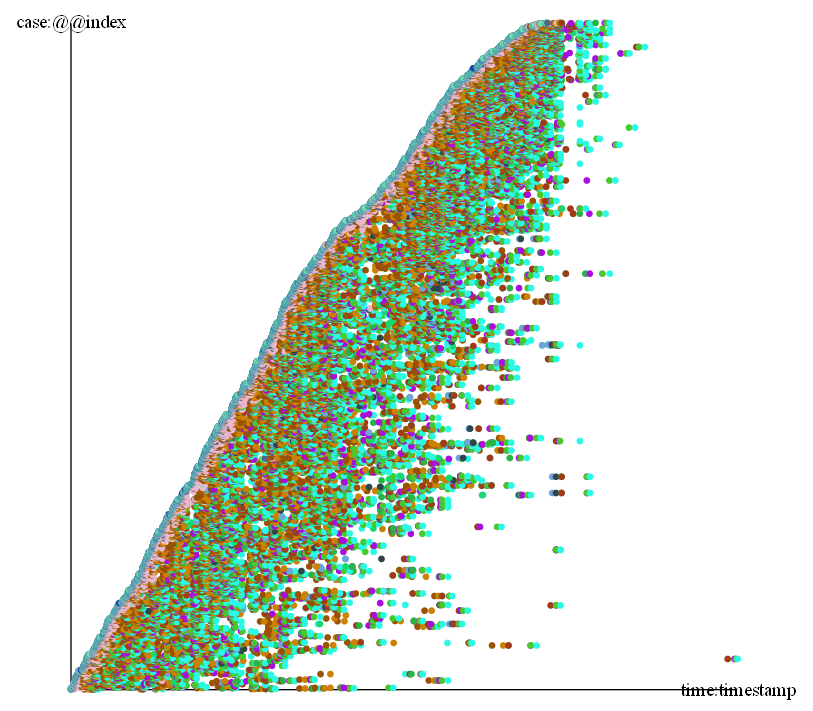

Non-Conforming Traces


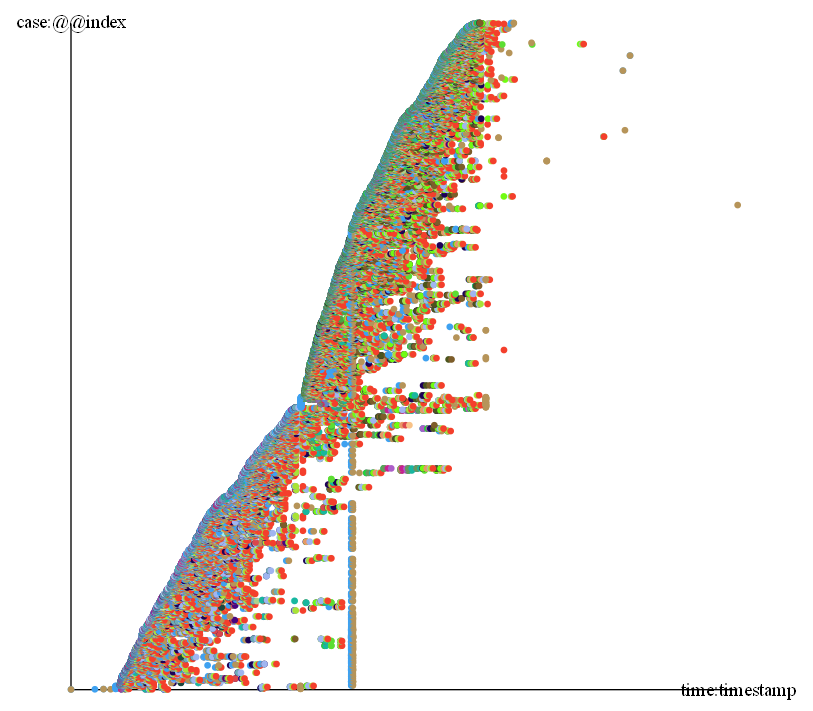

Filtered Non-Conforming Traces


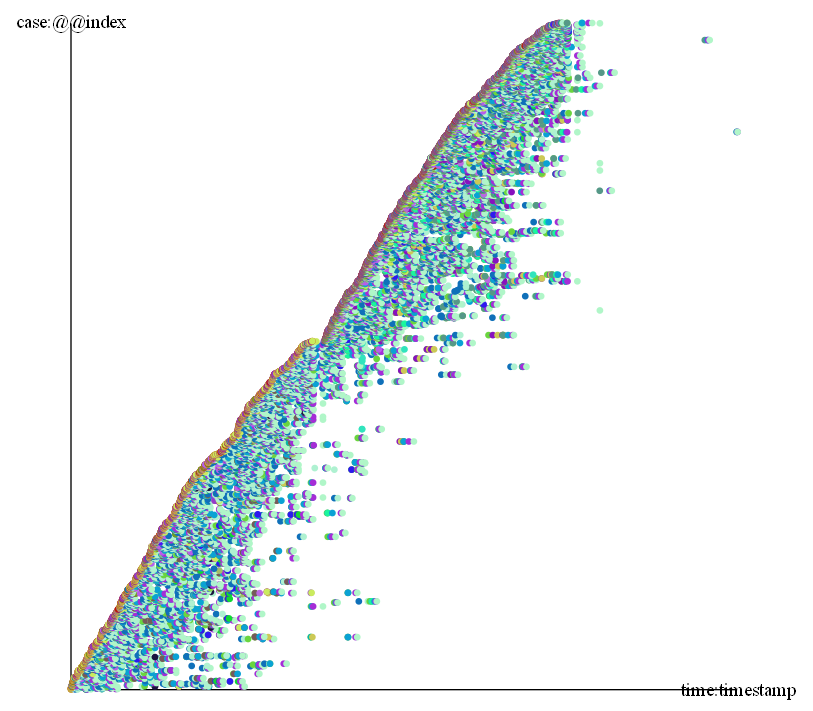

In [11]:
print("Conforming Traces")
pm4py.view_dotted_chart(conforming_log_df, show_legend = False)
print("Non-Conforming Traces")
pm4py.view_dotted_chart(non_conforming_log_df, show_legend = False)
print("Filtered Non-Conforming Traces")
pm4py.view_dotted_chart(filtered_non_conforming_log_df, show_legend = False)

### Trace Duration and Density of Events per Time

Conforming Traces


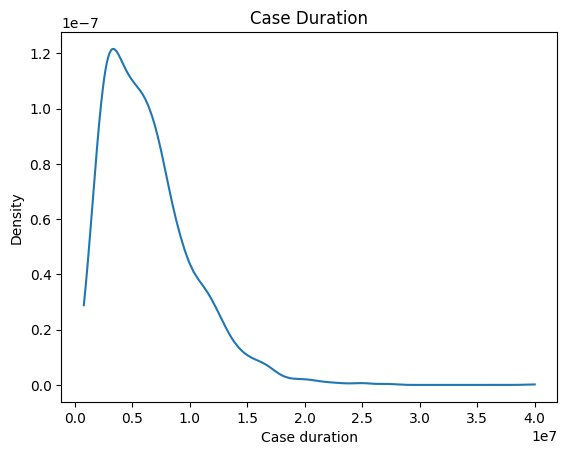

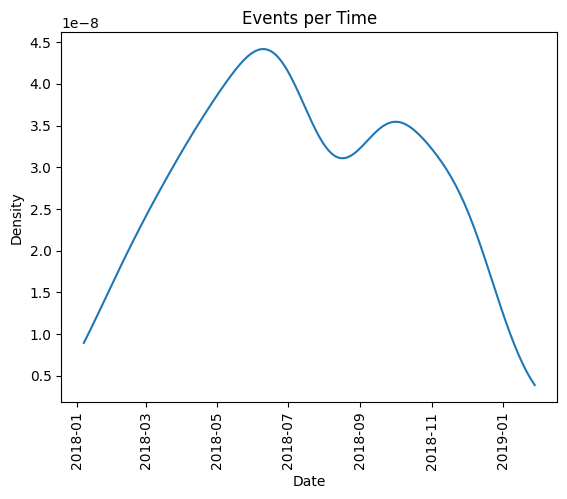

Filtered Non-Conforming Traces


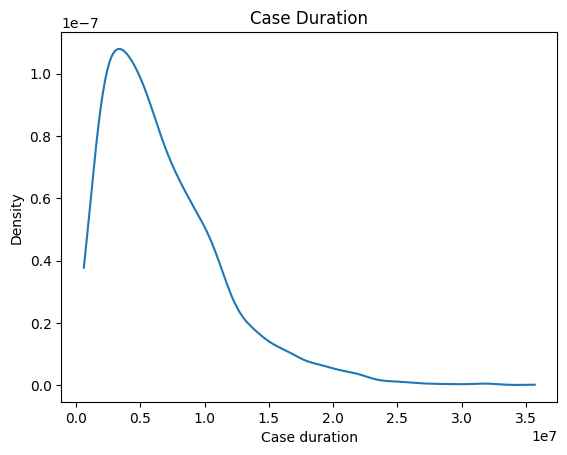

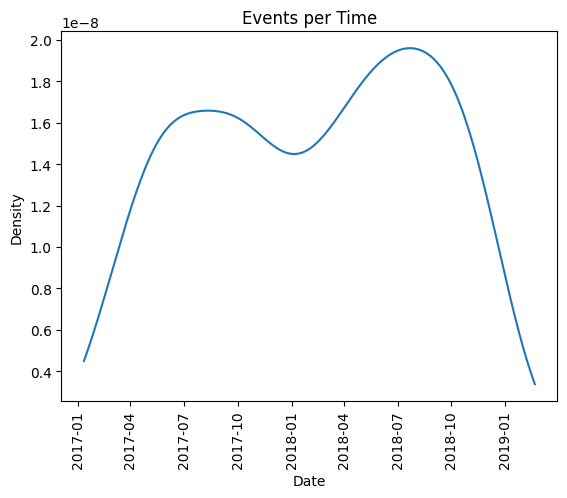

In [12]:
print("Conforming Traces")
pm4py.view_case_duration_graph(conforming_log_df)
pm4py.view_events_per_time_graph(conforming_log_df)
print("Filtered Non-Conforming Traces")
pm4py.view_case_duration_graph(filtered_non_conforming_log_df)
pm4py.view_events_per_time_graph(filtered_non_conforming_log_df)

## Aggregate Performance

In [25]:
def compare_logs_performance(conforming_log_df, non_conforming_log_df ):
    avg_length_conforming = conforming_log_df.groupby("case:concept:name").size().mean()
    avg_length_non_conforming = non_conforming_log_df.groupby("case:concept:name").size().mean()

    conforming_durations = (
        conforming_log_df.groupby("case:concept:name")["time:timestamp"].agg(["min", "max"])
    )
    conforming_durations["duration_days"] = (
        (conforming_durations["max"] - conforming_durations["min"]).dt.total_seconds() / (60 * 60 * 24)
    )
    avg_duration_conforming = conforming_durations["duration_days"].mean()
    std_duration_conforming = conforming_durations["duration_days"].std()
    median_duration_conforming = conforming_durations["duration_days"].median()

    non_conforming_durations = (
        non_conforming_log_df.groupby("case:concept:name")["time:timestamp"].agg(["min", "max"])
    )
    non_conforming_durations["duration_days"] = (
        (non_conforming_durations["max"] - non_conforming_durations["min"]).dt.total_seconds() / (60 * 60 * 24)
    )
    avg_duration_non_conforming = non_conforming_durations["duration_days"].mean()
    std_duration_non_conforming = non_conforming_durations["duration_days"].std()
    median_duration_non_conforming = non_conforming_durations["duration_days"].median()

    summary_stats = pd.DataFrame({
        "Log Type": ["Conforming", "Filtered Non-Conforming"],
        "Avg Trace Length (events)": [avg_length_conforming, avg_length_non_conforming],
        "Avg Trace Duration (days)": [avg_duration_conforming, avg_duration_non_conforming],
        "Median Trace Duration (days)": [median_duration_conforming, median_duration_non_conforming],
        "Std Dev Trace Duration (days)": [std_duration_conforming, std_duration_non_conforming]
    })

    styled_summary = summary_stats.style.format({
        "Avg Trace Length (events)": "{:.2f}",
        "Avg Trace Duration (days)": "{:.2f}",
        "Median Trace Duration (days)": "{:.2f}",
        "Std Dev Trace Duration (days)": "{:.2f}"
    }).set_properties(**{'text-align': 'center'}).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td:nth-child(1)', 'props': [('text-align', 'left')]}
    ]).hide(axis="index")

    display(styled_summary)

In [26]:
compare_logs_performance(conforming_log_df, filtered_non_conforming_log_df)

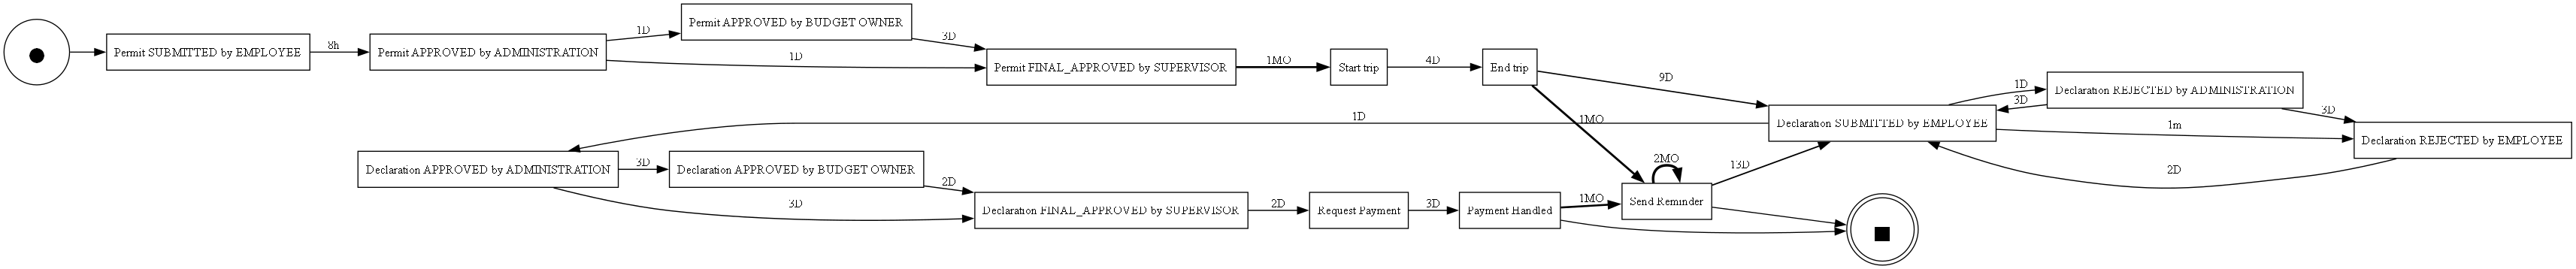

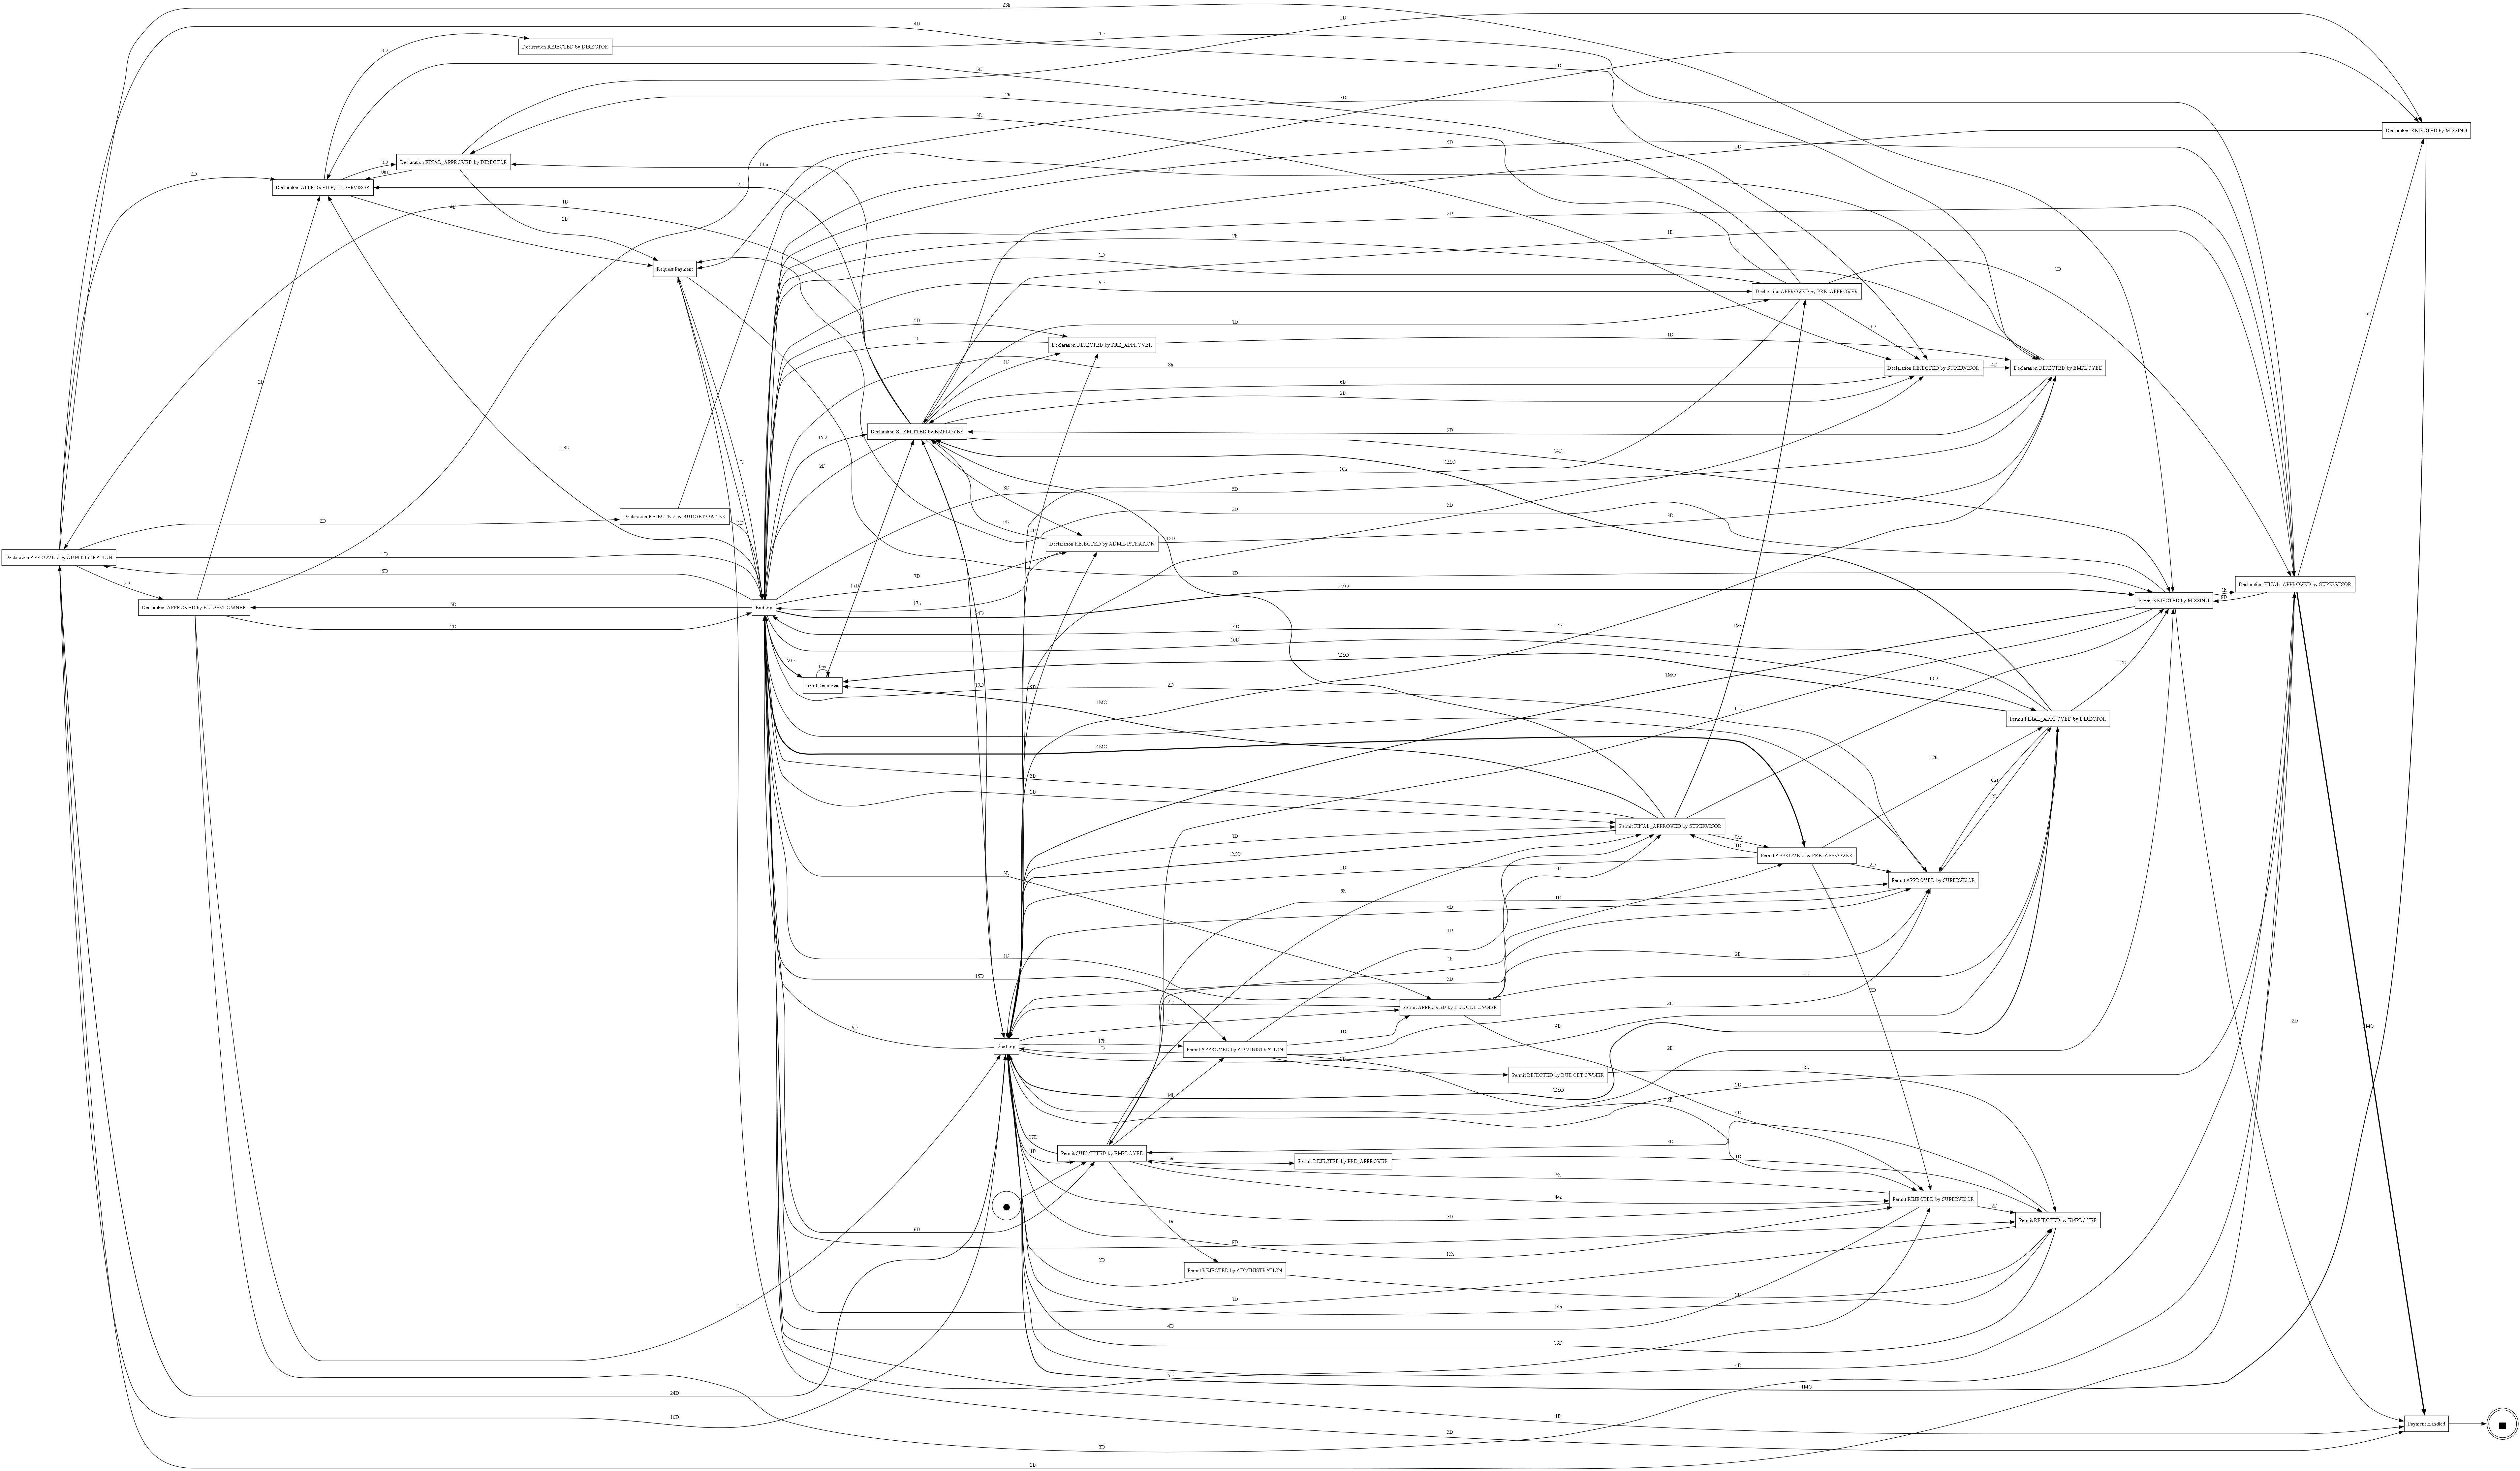

In [29]:
performance_conforming_dfg, start_c_activities, end_c_activities = pm4py.discover_performance_dfg(conforming_log_df, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
performance_filtered_non_conforming_dfg, start_fnc_activities, end_fnc_activities = pm4py.discover_performance_dfg(filtered_non_conforming_log_df, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
pm4py.view_performance_dfg(performance_conforming_dfg, start_c_activities, end_c_activities, format='png')
pm4py.view_performance_dfg(performance_filtered_non_conforming_dfg, start_fnc_activities, end_fnc_activities, format='png')

c:\Users\compt\AppData\Local\Programs\Python\Python310\lib\site-packages\pm4py\algo\discovery\performance_spectrum\variants\dataframe.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[activity_key] = dataframe[activity_key].astype("string")


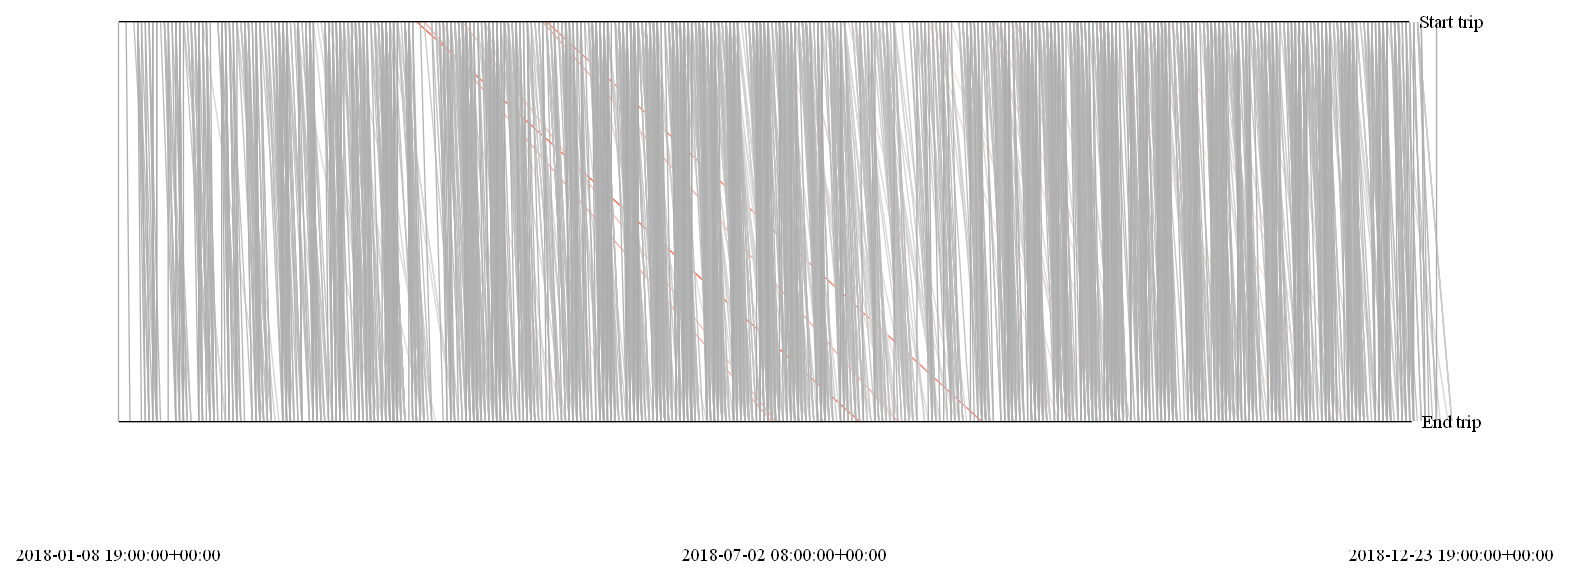

c:\Users\compt\AppData\Local\Programs\Python\Python310\lib\site-packages\pm4py\algo\discovery\performance_spectrum\variants\dataframe.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[activity_key] = dataframe[activity_key].astype("string")


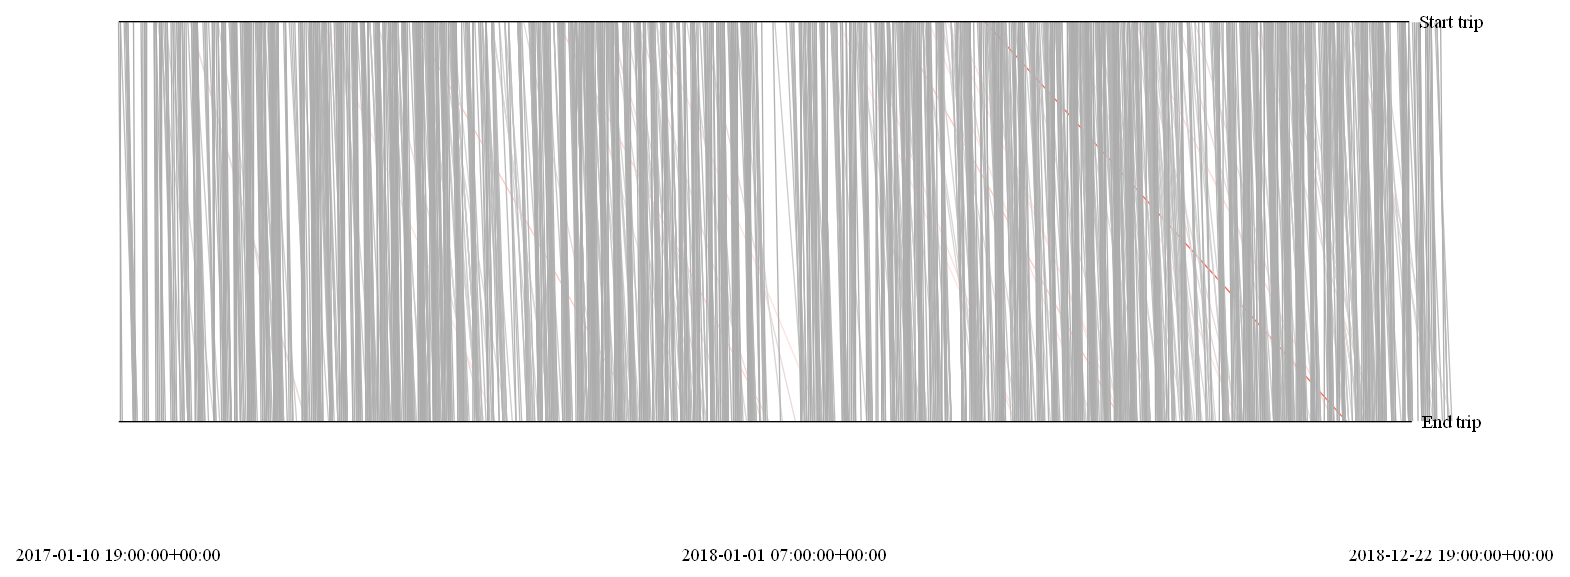

In [32]:
pm4py.view_performance_spectrum(conforming_log_df, ['Start trip', 'End trip'], format='png', activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
pm4py.view_performance_spectrum(filtered_non_conforming_log_df, ['Start trip', 'End trip'], format='png', activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

## Variants Analysis

In [14]:
def get_n_print_variants(event_log, log_name):
    variant_dictonary = pm4py.get_variants(
        event_log,
        activity_key='concept:name',
        case_id_key='case:concept:name',
        timestamp_key='time:timestamp'
    )

    print(f"The {sum(variant_dictonary.values())} traces in the {log_name} have {len(variant_dictonary)} variants")

    return variant_dictonary

In [15]:
variants_conforming_log = get_n_print_variants(conforming_log_df, log_name="Conforming Log")
variants_filtered_non_conforming_log = get_n_print_variants(filtered_non_conforming_log_df, log_name="Filtered Non-Conforming Log")

The 2912 traces in the Conforming Log have 40 variants
The 2106 traces in the Filtered Non-Conforming Log have 391 variants


In [16]:
def top_N_variants_Pareto_chartd(variants, Top_N, log_name):

    variant_stats = sorted(variants.items(), key=lambda x: x[1], reverse=True)

    top_variant_stats = variant_stats[:Top_N]

    x = [f"V{i+1}" for i in range(len(top_variant_stats))]
    y = [v[1] for v in top_variant_stats]

    cumulative = np.cumsum(y)
    cumulative_percent = cumulative / cumulative[-1] * 100

    fig, ax1 = plt.subplots(figsize=(24, 6))

    ax1.bar(x, y, color='blue')
    ax1.set_ylabel('Frequency', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(x, cumulative_percent, color='red', marker='o')
    ax2.set_ylabel('Cumulative %', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.axhline(80, color='gray', linestyle='--')

    plt.title(f"Pareto Chart of Trace Variants from {log_name}")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

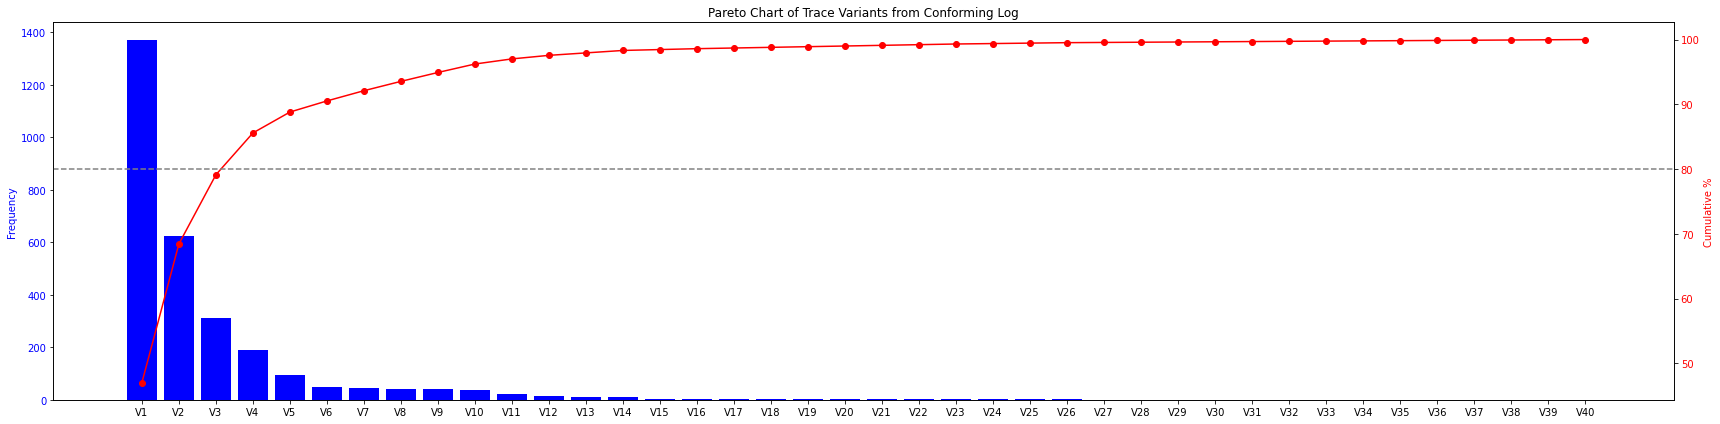

In [22]:
top_N_variants_Pareto_chartd(variants_conforming_log, Top_N=40, log_name="Conforming Log")

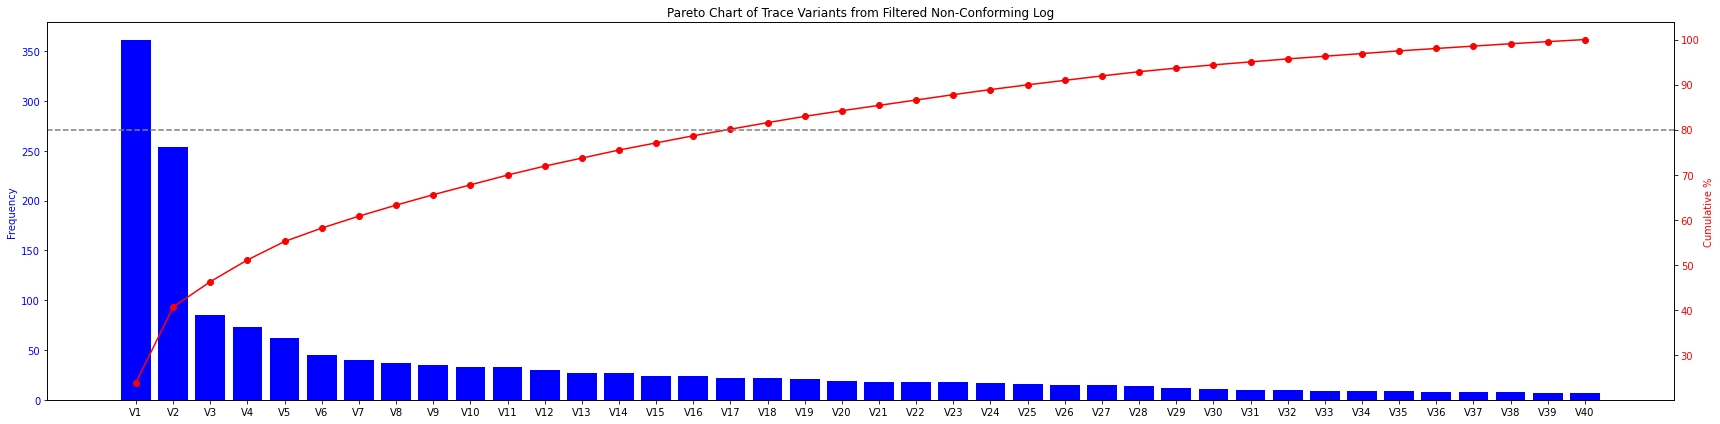

In [23]:
top_N_variants_Pareto_chartd(variants_filtered_non_conforming_log, Top_N=40, log_name="Filtered Non-Conforming Log")

## Saving Event Logs

In [ ]:
#conforming_log_df.to_pickle("conforming-log.pkl")
#filtered_non_conforming_log_df.to_pickle("filtered-non-conforminlog.pkl")